In [1]:
import tqdm
import numpy as np
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
from scipy.stats import binom

from database import YaleStarCatalog, StarCatalog
from utils.unit_convert import deg2rad
from utils.font import font_setting


font_setting()

DPI = 100
FIG_SIZE = (12, 7)

In [2]:
### Parameter ###
# sys
log_dir = './log/'
# config
master_seed = 10
FOV_deg = 40
FOV = deg2rad(FOV_deg)
roopN = int(1e5)
calcN = int(1e4)
# catalog
Mv_max = 5.5
Mv_obs = 5.5
multi_angle = 1.0e-5

In [3]:
def equatorial2vec(alpha, delta):
    rets = np.empty((len(alpha), 3))
    rets[:, 0] = np.cos(alpha) * np.cos(delta)
    rets[:, 1] = np.sin(alpha) * np.cos(delta)
    rets[:, 2] = np.sin(delta)
    return rets

def rotate(R, vec):
    ret = np.empty((R.shape[0], vec.shape[0], vec.shape[1]))
    for i in range(R.shape[0]):
        ret[i, :, :] = np.dot(R[i], vec.T).T
    return ret

----- Yale Bright Star Catalog -----
the number of stars : 9096
the range of magnitude : [-1.46, 7.96]


Text(0, 0.5, 'Declination')

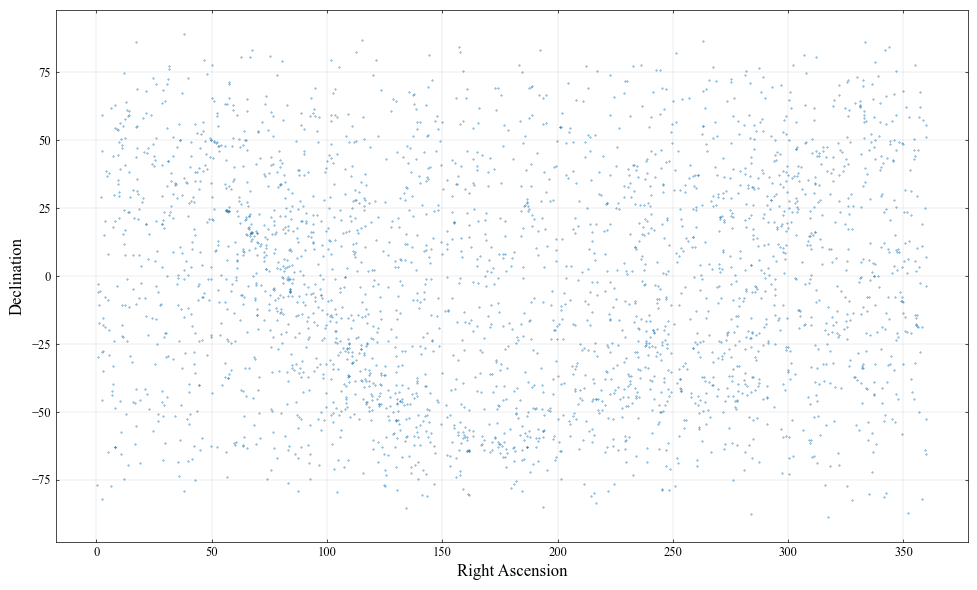

In [5]:
### Catalog setup ###
yale = YaleStarCatalog(log_dir=log_dir)
# 
obs_star_ctlg = StarCatalog(yale.get_HR(), yale.get_RA(), yale.get_DE())
obs_star_ctlg.filtering_by_visual_magnitude(yale.get_Vmag(), Mv_max)
obs_star_ctlg.filtering_by_multiple_stars(multi_angle)    
obs_star_ctlg.filtering_by_visual_magnitude(yale.get_Vmag(), Mv_obs)
eq_vec = equatorial2vec(obs_star_ctlg.get_RA(), obs_star_ctlg.get_DE())

# plot 
fig = plt.figure(figsize=FIG_SIZE, dpi=DPI)
ax = fig.add_subplot(111)

ax.scatter(obs_star_ctlg.get_RA()*180/np.pi, obs_star_ctlg.get_DE()*180/np.pi, s=0.1)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

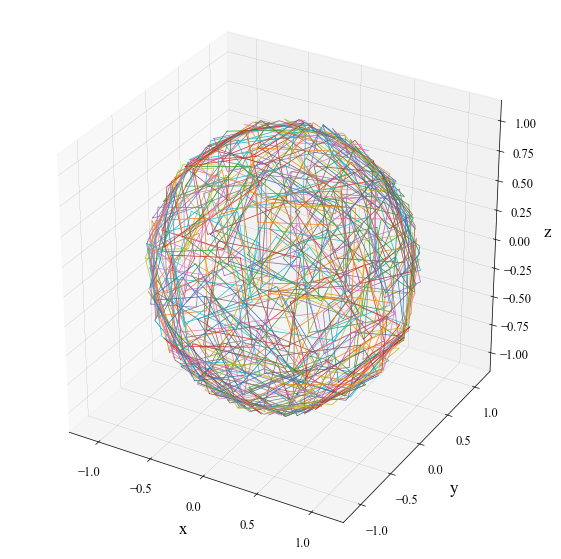

In [6]:
### random rotation matrix ###
N = 200
e_z = np.array([0, 0, 1.0])
edge1 = np.array([np.tan(FOV/2.0), np.tan(FOV/2.0), 1.0])
edge2 = np.array([-np.tan(FOV/2.0), np.tan(FOV/2.0), 1.0])
edge3 = np.array([-np.tan(FOV/2.0), -np.tan(FOV/2.0), 1.0])
edge4 = np.array([np.tan(FOV/2.0), -np.tan(FOV/2.0), 1.0])
R = special_ortho_group.rvs(dim=3, size=N)
edge1_R = rotate(R, edge1[np.newaxis, :])
edge2_R = rotate(R, edge2[np.newaxis, :])
edge3_R = rotate(R, edge3[np.newaxis, :])
edge4_R = rotate(R, edge4[np.newaxis, :])

# plot 
fig = plt.figure(figsize=FIG_SIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='3d')
for i in range(N):
    ax.plot(
        [edge1_R[i, 0, 0], edge2_R[i, 0, 0], edge3_R[i, 0, 0], edge4_R[i, 0, 0], edge1_R[i, 0, 0]],
        [edge1_R[i, 0, 1], edge2_R[i, 0, 1], edge3_R[i, 0, 1], edge4_R[i, 0, 1], edge1_R[i, 0, 1]],
        [edge1_R[i, 0, 2], edge2_R[i, 0, 2], edge3_R[i, 0, 2], edge4_R[i, 0, 2], edge1_R[i, 0, 2]],
        lw = 0.5
    )
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_box_aspect((1,1,1))

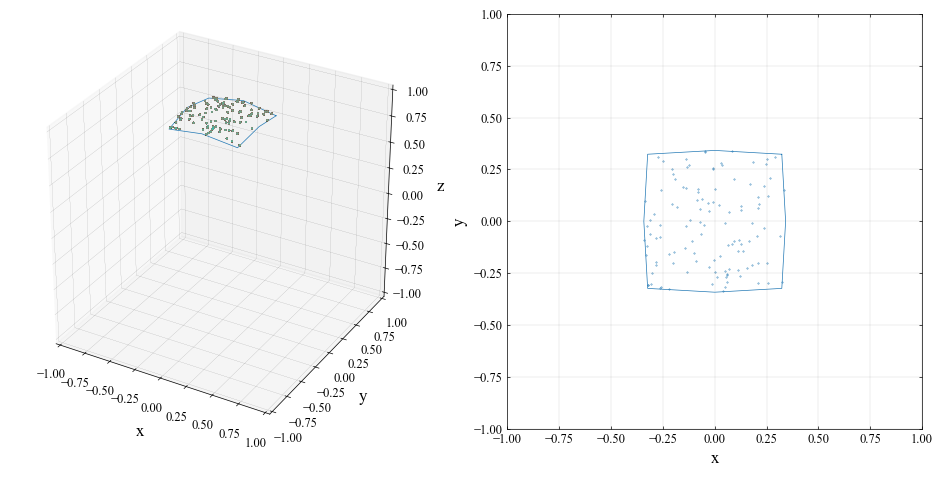

In [7]:
### inFOV condition ###
R = special_ortho_group.rvs(dim=3, size=10)
eq_vec_R = rotate(R, eq_vec)
# FOV condition
cond_1 = eq_vec_R[:, :, 2] > 0.0
temp = np.tan(FOV/2.0)*eq_vec_R[:, :, 2]
cond_2 = np.abs(eq_vec_R[:, :, 0]) < temp
cond_3 = np.abs(eq_vec_R[:, :, 1]) < temp
in_FOV = cond_1 * cond_2 * cond_3

inFOV_points = eq_vec_R[0, in_FOV[0]]

edge1 = np.array([np.tan(FOV/2.0), np.tan(FOV/2.0), 1.0])
edge2 = np.array([0.0, np.tan(FOV/2.0), 1.0])
edge3 = np.array([-np.tan(FOV/2.0), np.tan(FOV/2.0), 1.0])
edge4 = np.array([-np.tan(FOV/2.0), 0.0, 1.0])
edge5 = np.array([-np.tan(FOV/2.0), -np.tan(FOV/2.0), 1.0])
edge6 = np.array([0.0, -np.tan(FOV/2.0), 1.0])
edge7 = np.array([np.tan(FOV/2.0), -np.tan(FOV/2.0), 1.0])
edge8 = np.array([np.tan(FOV/2.0), 0.0, 1.0])
edge1 = edge1/np.linalg.norm(edge1)
edge2 = edge2/np.linalg.norm(edge2)
edge3 = edge3/np.linalg.norm(edge3)
edge4 = edge4/np.linalg.norm(edge4)
edge5 = edge5/np.linalg.norm(edge5)
edge6 = edge6/np.linalg.norm(edge6)
edge7 = edge7/np.linalg.norm(edge7)
edge8 = edge8/np.linalg.norm(edge8)
# plot
fig = plt.figure(figsize=FIG_SIZE, dpi=DPI)
ax = fig.add_subplot(121, projection='3d')
for i in range(N):
    ax.scatter(inFOV_points[:, 0], inFOV_points[:, 1], inFOV_points[:, 2], s=0.1)
ax.plot(
    [edge1[0], edge2[0], edge3[0], edge4[0], edge5[0], edge6[0], edge7[0], edge8[0], edge1[0]],
    [edge1[1], edge2[1], edge3[1], edge4[1], edge5[1], edge6[1], edge7[1], edge8[1], edge1[1]],
    [edge1[2], edge2[2], edge3[2], edge4[2], edge5[2], edge6[2], edge7[2], edge8[2], edge1[2]],
    lw = 0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_box_aspect((1,1,1))

ax = fig.add_subplot(122)
ax.scatter(inFOV_points[:, 0], inFOV_points[:, 1], s=0.1)
ax.plot(
    [edge1[0], edge2[0], edge3[0], edge4[0], edge5[0], edge6[0], edge7[0], edge8[0], edge1[0]],
    [edge1[1], edge2[1], edge3[1], edge4[1], edge5[1], edge6[1], edge7[1], edge8[1], edge1[1]],
    lw = 0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')